# Run johns simulation using my datasets on a subsample of the data

In [8]:
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import numpy as np
import replicaEVSE.load_curve as sim
import os
from dask.diagnostics import ProgressBar
import joblib

%reload_ext autoreload
%autoreload 2



pd.set_option('display.max_columns', None)

datadir = '../../data'

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default

pbar = ProgressBar()
pbar.register()

#Created in the EIA_data_download.ipynb notebook
existing_load=pd.read_csv('../../data/EIA_demand_summary.csv') 

merged_ddf = dd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips.parquet'))

df = merged_ddf.head(10000)
ddf = dd.from_pandas(df, npartitions=4)


# right now, only look at private auto trips
ddf = ddf.loc[ddf['mode'] == 'PRIVATE_AUTO']



# sort on person_id and start_time
ddf = ddf.sort_values(by=['person_id', 'start_time', 'weekday']).reset_index(drop=True)

ddf = ddf.reset_index(drop=True)
df = ddf.compute()


/home/matthew.wilde@RMI.local/mambaforge/envs/py311/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40059 instead
  warnings.warn(


In [58]:
# this data set only includes trips with people who are also in the population data set
# this means no COMMERCIAL trips
len(merged_ddf)

51727268

In [9]:
print(client)

<Client: 'tcp://127.0.0.1:38965' processes=4 threads=8, memory=31.35 GiB>


### run the simulation on small dataset to test

In [115]:
# this takes ~1min for 10,000 trips
out = sim.simulate_person_load(df, existing_load, 'base', managed=False)

In [208]:
# try to use dask
# this doesn't work
# out = ddf.map_partitions(sim.simulate_person_load, existing_load, 'base', managed=False, align_dataframes=False)
# out.compute()

In [10]:
number_of_chunks = 10000 # 10000 rows in each chunck
df_list = np.array_split(df, number_of_chunks)

NameError: name 'number_of_chunks' is not defined

In [209]:
# run the simulation in parallel
# df must be a pandas dataframe
charge_sims = joblib.Parallel(verbose=10, n_jobs=-1)(
    joblib.delayed(sim.simulate_person_load)(
    df=df,
    existing_load=existing_load,
    simulation_id='base',
    managed=False
) for df in df_list)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [191]:
# restack the dataframes
charges_list = [x['charges'] for x in charge_sims]
charges_df = pd.concat(charges_list)

loads_list = [x['loads'] for x in charge_sims]
loads_df = pd.concat(loads_list)

In [194]:
frac = 0.001 # ~2e4
thu = dd.read_parquet(os.path.join(datadir, 'northwest_2021_Q4_thursday_trip.parquet'))
sat = dd.read_parquet(os.path.join(datadir, 'northwest_2021_Q4_saturday_trip.parquet'))
pop = dd.read_parquet(os.path.join(datadir, 'northwest_2021_Q4_population.parquet'))
ddf = dd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips.parquet'))
df = ddf.head(10000000)
trips_ddf = dd.concat([thu, sat])
# ddf = dd.from_pandas(df, chunksize=1000)
df['mode'].value_counts()

/Users/matthew.wilde/mambaforge/envs/py311/lib/python3.11/site-packages/dask/dataframe/core.py:7996: UserWarning: Insufficient elements for `head`. 10000000 elements requested, only 92208 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


PRIVATE_AUTO         48293
CARPOOL              29286
WALKING               8937
COMMERCIAL            2581
OTHER_TRAVEL_MODE     1146
ON_DEMAND_AUTO         791
PUBLIC_TRANSIT         707
BIKING                 467
Name: mode, dtype: int64

2023-04-29 13:05:06,592 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 1 memory: 28 MB fds: 44>>
Traceback (most recent call last):
  File "/Users/matthew.wilde/mambaforge/envs/py311/lib/python3.11/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
          ^^^^^^^^^^^^^^^
  File "/Users/matthew.wilde/mambaforge/envs/py311/lib/python3.11/site-packages/distributed/system_monitor.py", line 164, in update
    net_ioc = psutil.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/matthew.wilde/mambaforge/envs/py311/lib/python3.11/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 12] Cannot allocate memory
2023-04-29 13:05:06,592 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 1 memory: 27 MB fds: 44

In [193]:
len(trips_ddf.loc[trips_ddf['mode'] == 'PRIVATE_AUTO'])

58222322

In [195]:
len(sat) + len(thu), len(ddf), len(pop)

(107897185, 51727268, 14889896)

In [204]:
pop_len = 58.222322
trips_len = 159.624453 # million
join_len = 51.727268 
other_len = 49.674863
pop_len = 14.889896

In [207]:
unique_people_in_pop_len = len(pop['person_id'].unique())


In [200]:
trucks = trips_ddf.loc[trips_ddf['mode'] == 'COMMERCIAL']
other = trips_ddf.loc[trips_ddf['mode'] != 'PRIVATE_AUTO']

In [201]:
len(other)

49674863

In [43]:
trucks['person_id'].value_counts()

742346565412155034      1
15599841864145516296    1
15957102494379320837    1
527913541642522316      1
11863695826646875355    1
                       ..
10609809864126162799    1
13047083034364930310    1
4870148386369669563     1
3820212310910378094     1
8815481925946782109     1
Name: person_id, Length: 12957, dtype: int64

<Axes: >

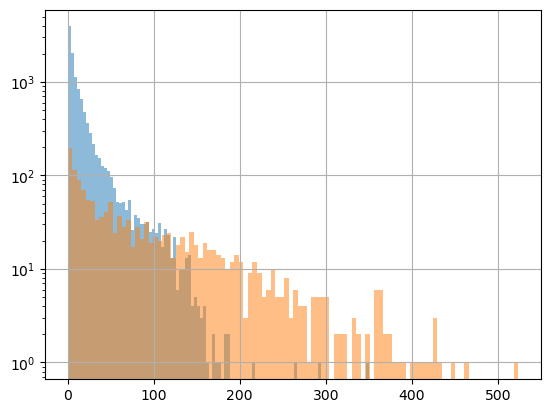

In [47]:
trucks.loc[trucks['vehicle_type'] == 'MEDIUM_COMMERCIAL']['distance_miles'].hist(bins=100,  alpha=0.5)
trucks.loc[trucks['vehicle_type'] == 'HEAVY_COMMERCIAL']['distance_miles'].hist(bins=100, log=True, alpha=0.5)

In [38]:
trips = dd.read_parquet(os.path.join(datadir, 'northwest_2021_Q4_thursday_trip.parquet'))